# Interpolation

**Goals**  
- Construct polynomial (Lagrange/Newton) and piecewise (linear, cubic spline, PCHIP) interpolants  
- Control oscillations via Chebyshev nodes and understand the Runge phenomenon  
- Extend to 2D tensor‐product and scattered‐data methods (`griddata`, RBF)  

**Applications**  
- Reconstruct pipe‐flow velocity profiles and compute wall‐shear  
- Interpolate airfoil $C_p(x)$ to estimate lift  
- Resample 2D CFD fields from coarse to fine grids  


## Polynomial interpolation: Lagrange & Newton forms

Given nodes $x_0,\dots,x_n$ with values $f_i = f(x_i)$, the **Lagrange** interpolant is

$$
P_n(x) = \sum_{j=0}^n f_j\,\ell_j(x),
\quad
\ell_j(x) = \prod_{\substack{i=0\\i\neq j}}^n \frac{x - x_i}{x_j - x_i}\,.
$$

The **Newton** form builds the same $P_n$ via divided differences:

$$
P_n(x) 
= a_0 + a_1(x - x_0) + a_2(x - x_0)(x - x_1) + \cdots
+ a_n\prod_{i=0}^{n-1}(x - x_i)\,,
$$

where the coefficients 
$\displaystyle a_k = f[x_0,\dots,x_k]$ come from the recursion

$$
f[x_i] = f_i,\quad 
f[x_i,x_{i+1}] = \frac{f_{i+1}-f_i}{x_{i+1}-x_i},\quad 
f[x_i,\dots,x_{i+k}] = \frac{f[x_{i+1},\dots,x_{i+k}] - f[x_i,\dots,x_{i+k-1}]}{x_{i+k}-x_i}.
$$

Both yield the same polynomial but differ in how they’re computed and updated.

**Example (pipe flow)**  
Reconstruct the laminar‐pipe velocity profile

$$
u(r) = u_{\max}\Bigl(1 - \frac{r^2}{R^2}\Bigr),\quad 0\le r\le R,
$$

from 5 samples $(r_i,u_i)$, and compare the Lagrange and Newton interpolants.


## import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# ---- Sample data for pipe flow profile ----
u_max, R = 1.0, 1.0
r_nodes = np.linspace(0, R, 5)
u_nodes = u_max * (1 - (r_nodes/R)**2)

# ---- Lagrange interpolant via SciPy ----
poly_L = lagrange(r_nodes, u_nodes)

# ---- Newton divided differences implementation ----
def divided_differences(x, y):
    n = len(x)
    coef = y.copy()
    for j in range(1, n):
        coef[j:] = (coef[j:] - coef[j-1:-1]) / (x[j:] - x[:-j])
    return coef

def newton_eval(coef, x_nodes, x):
    n = len(coef)
    p = coef[-1]
    for k in range(n-2, -1, -1):
        p = p*(x - x_nodes[k]) + coef[k]
    return p

coef = divided_differences(r_nodes, u_nodes)

# ---- Evaluate on a fine grid ----
r_fine = np.linspace(0, R, 200)
u_L = poly_L(r_fine)
u_N = newton_eval(coef, r_nodes, r_fine)

# ---- Plotting ----
plt.plot(r_fine/R, u_L/u_max, '-', label='Lagrange')
plt.plot(r_fine/R, u_N/u_max, '--', label='Newton')
plt.plot(r_nodes/R, u_nodes/u_max, 'o', label='sample nodes')
plt.xlabel(r'$r/R$'); plt.ylabel(r'$u/u_{\max}$')
plt.title('Polynomial Interpolation of Pipe‑Flow Profile')
plt.legend(); plt.grid(True); plt.show()


## Common pitfalls

#### Example 1: Runge phenomenon with **Lagrange** interpolation

The Runge function  

$$
f(x)=\frac1{1+25x^2},\quad x\in[-1,1],
$$  

is smooth but a high‑degree interpolant on **equispaced** nodes oscillates wildly near the ends. In contrast, using **Chebyshev** nodes  

$$
x_j = \cos\!\Bigl(\frac{2j+1}{2(n+1)}\pi\Bigr),\quad j=0,\dots,n
$$  

clusters points at $\pm1$ and suppresses the blow‑up.


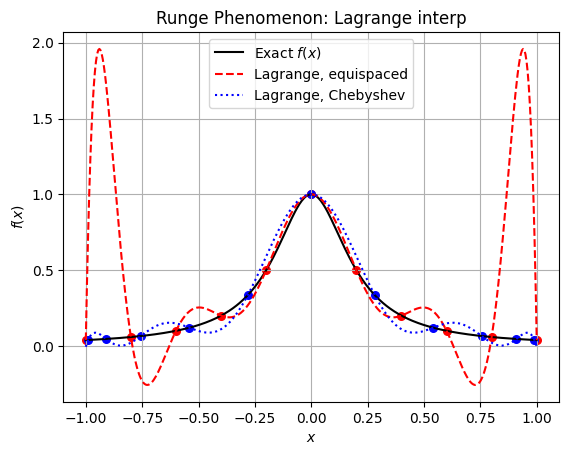

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# Runge function
f = lambda x: 1/(1 + 25*x**2)
n = 10

# Equispaced nodes
x_e = np.linspace(-1, 1, n+1)
y_e = f(x_e)
poly_e = lagrange(x_e, y_e)

# Chebyshev nodes
j = np.arange(n+1)
x_c = np.cos((2*j+1)/(2*(n+1))*np.pi)
y_c = f(x_c)
poly_c = lagrange(x_c, y_c)

# Evaluate on fine grid
x = np.linspace(-1, 1, 400)
plt.plot(x, f(x), 'k', label='Exact $f(x)$')
plt.plot(x, poly_e(x), '--r', label='Lagrange, equispaced')
plt.plot(x, poly_c(x), ':b', label='Lagrange, Chebyshev')
plt.scatter(x_e, y_e, color='r', s=30)
plt.scatter(x_c, y_c, color='b', s=30)
plt.title('Runge Phenomenon: Lagrange interp')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.legend(); plt.grid(True); plt.show()


#### Example 2: Non‑smooth target $f(x)=|x|$ with **Newton** form

For the kinked function  

$$
f(x)=|x|,\quad x\in[-1,1],
$$  

the global polynomial interpolant overshoots near $x=0$. Here we build the Newton form via divided differences:

$$
P_n(x)=a_0 + a_1(x-x_0) + \cdots + a_n\prod_{i=0}^{n-1}(x-x_i),
\quad a_k = f[x_0,\dots,x_k].
$$


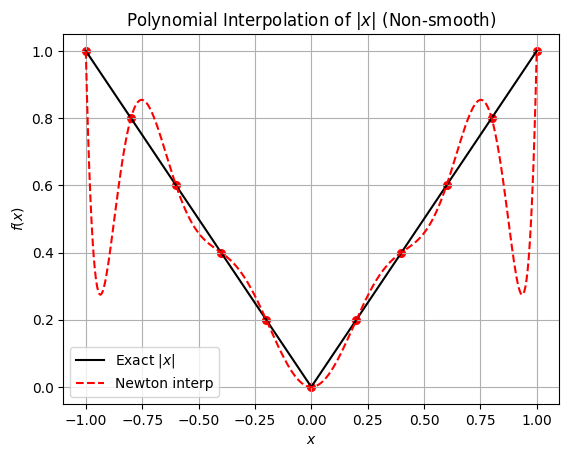

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define f and nodes
f = lambda x: np.abs(x)
n = 10
x_nodes = np.linspace(-1, 1, n+1)
y_nodes = f(x_nodes)

# Compute divided differences
def divided_differences(x, y):
    coef = y.copy().astype(float)
    for j in range(1, len(x)):
        coef[j:] = (coef[j:] - coef[j-1:-1]) / (x[j:] - x[:-j])
    return coef

def newton_eval(coef, x_nodes, x):
    p = coef[-1]
    for k in range(len(coef)-2, -1, -1):
        p = p*(x - x_nodes[k]) + coef[k]
    return p

coef = divided_differences(x_nodes, y_nodes)

# Plot
x = np.linspace(-1, 1, 400)
y_interp = newton_eval(coef, x_nodes, x)

plt.plot(x, f(x), 'k', label='Exact $|x|$')
plt.plot(x, y_interp, '--r', label='Newton interp')
plt.scatter(x_nodes, y_nodes, color='r', s=30)
plt.title('Polynomial Interpolation of $|x|$ (Non‑smooth)')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.legend(); plt.grid(True); plt.show()


## Piecewise interpolants: linear, cubic spline & PCHIP

Given data points $(x_i,y_i)$, a **piecewise linear** interpolant connects each $(x_i,y_i)$ to $(x_{i+1},y_{i+1})$ by a straight line.  A **cubic spline** $S(x)$ is a piecewise cubic with $S,S',S''$ continuous at the knots, usually satisfying “natural” boundary conditions $S''(x_0)=S''(x_n)=0$.  **PCHIP** (Piecewise Cubic Hermite) also uses piecewise cubics but enforces monotonicity by matching one‐sided derivatives.

On each interval $[x_i,x_{i+1}]$:
- **Linear**: $S(x)=y_i + \frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i)$  
- **Spline**: solves $\;S''(x_i)=0\;(i=0,n)$ plus continuity of $S,S',S''$  
- **PCHIP**: imposes $S(x_i)=y_i$, $S'(x_i)$ from local slopes, avoiding overshoot

Below we load hot‐wire measurements (stored in folder `./12-files`) of a pipe‐flow profile from a CSV file and compare the three interpolants.


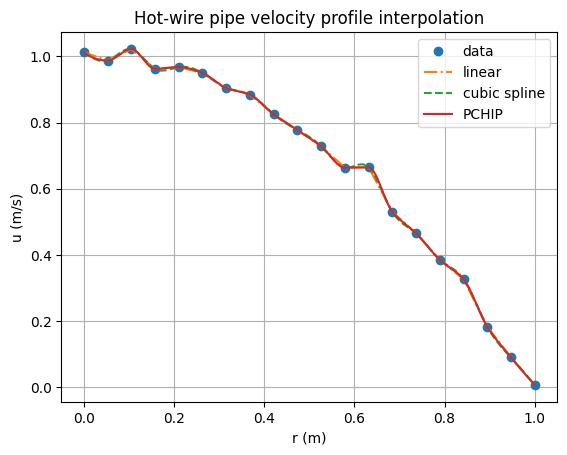

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator

# --- load experimental data from ./12-files/ ---
data = pd.read_csv('./12-files/hotwire_pipe_profile.csv')
r_meas = data['r'].values
u_meas = data['u'].values

# --- build interpolants ---
lin_interp   = interp1d(r_meas, u_meas, kind='linear')
spl_interp   = CubicSpline(r_meas, u_meas, bc_type='natural')
pchip_interp = PchipInterpolator(r_meas, u_meas)

# --- evaluate on fine grid ---
r_fine = np.linspace(r_meas.min(), r_meas.max(), 300)
u_lin   = lin_interp(r_fine)
u_spl   = spl_interp(r_fine)
u_pchip = pchip_interp(r_fine)

# --- plot ---
plt.plot(r_meas, u_meas, 'o', label='data')
plt.plot(r_fine, u_lin,   '-.', label='linear')
plt.plot(r_fine, u_spl,   '--', label='cubic spline')
plt.plot(r_fine, u_pchip, '-', label='PCHIP')
plt.xlabel('r (m)'); plt.ylabel('u (m/s)')
plt.title('Hot‐wire pipe velocity profile interpolation')
plt.legend(); plt.grid(True); plt.show()


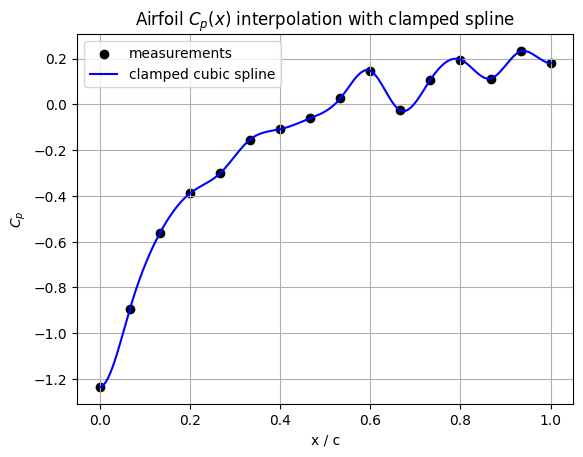

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# --- load Cp data from ./12-files/ ---
df = pd.read_csv('./12-files/airfoil_Cp.csv')
x, Cp = df['x'].values, df['Cp'].values

# --- build clamped spline: Cp'(0)=0, Cp'(1)=0 ---
cs_clamped = CubicSpline(x, Cp, bc_type=((1, 0.0), (1, 0.0)))

# --- evaluate & plot ---
x_fine = np.linspace(0, 1, 400)
Cp_fine = cs_clamped(x_fine)

plt.scatter(x, Cp, color='k', label='measurements')
plt.plot(x_fine, Cp_fine, 'b-', label='clamped cubic spline')
# plt.gca().invert_yaxis()  # Cp plotted negative-up convention
plt.xlabel('x / c'); plt.ylabel('$C_p$')
plt.title('Airfoil $C_p(x)$ interpolation with clamped spline')
plt.legend(); plt.grid(True); plt.show()


#### ⚠️ Working with CSV files in pandas

A **CSV** (Comma‑Separated Values) file is a plain‑text table where each line represents a row and columns are separated by commas. It’s a common format for exporting experimental or simulation data.

To read a CSV into pandas:

```python
import pandas as pd
df = pd.read_csv('path/to/your/file.csv')

## 2D tensor‑product interpolation

When $f(x,y)$ is sampled on a regular grid  
$$
\{x_i\}_{i=0}^m,\;\{y_j\}_{j=0}^n,\quad z_{ij}=f(x_i,y_j),
$$  
we can build a **tensor‑product interpolant** by applying 1D interpolation in each direction. SciPy’s `RegularGridInterpolator` handles this:

- **Linear**: bilinear on each cell  
- **Cubic**: bicubic spline on each cell  

Below we sample a model vortex‐core field  
$$
f(x,y)=\exp\!\Bigl(-\frac{(x-0.5)^2+(y-0.5)^2}{\sigma^2}\Bigr),
\quad\sigma^2=0.02,
$$  
on a coarse grid, then interpolate to a finer grid.


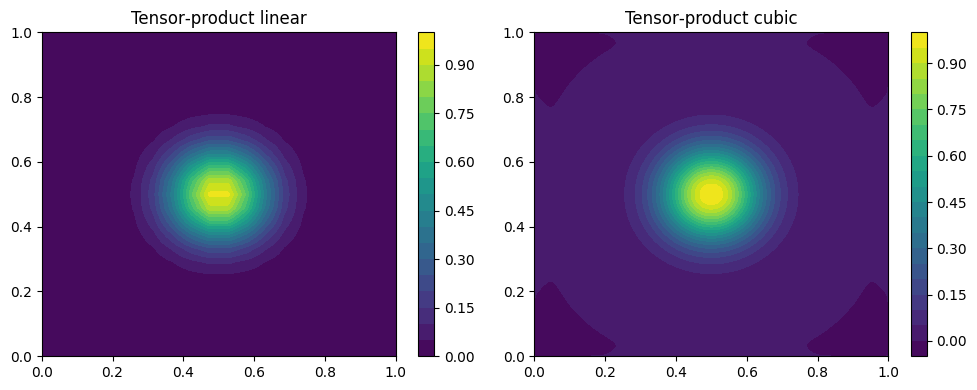

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# coarse grid
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 25)
Xc, Yc = np.meshgrid(x, y, indexing='ij')  
f = lambda x, y: np.exp(-((x-0.5)**2 + (y-0.5)**2)/0.02)
Zc = f(Xc, Yc)

# create interpolators
lin_interp = RegularGridInterpolator((x, y), Zc, method='linear')
cub_interp = RegularGridInterpolator((x, y), Zc, method='cubic')

# fine grid
xf = np.linspace(0, 1, 200)
yf = np.linspace(0, 1, 200)
Xf, Yf = np.meshgrid(xf, yf, indexing='ij')
pts = np.stack((Xf.ravel(), Yf.ravel()), axis=-1)

Z_lin = lin_interp(pts).reshape(Xf.shape)
Z_cub = cub_interp(pts).reshape(Xf.shape)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
c1 = ax1.contourf(Xf, Yf, Z_lin, levels=20)
ax1.set_title('Tensor‑product linear')
fig.colorbar(c1, ax=ax1)
c2 = ax2.contourf(Xf, Yf, Z_cub, levels=20)
ax2.set_title('Tensor‑product cubic')
fig.colorbar(c2, ax=ax2)
plt.tight_layout(); plt.show()


#### Scattered‑data interpolation: `griddata` vs. RBF

When data are **unstructured** $(x_i,y_i,f_i)$, SciPy offers:

- `griddata(..., method='linear'/'cubic')`: piecewise interpolation on Delaunay triangulation  
- `Rbf`: global radial‐basis‐function interpolant (e.g.\ multiquadric, Gaussian)

Here we randomly sample the same vortex field on scattered points and reconstruct it on a regular grid using both approaches.


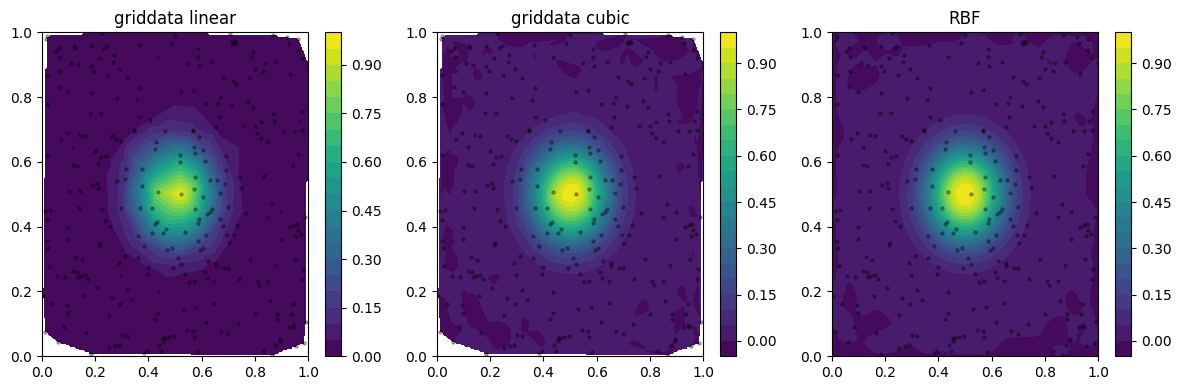

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, Rbf

# scattered samples
np.random.seed(0)
N = 300
xs = np.random.rand(N)
ys = np.random.rand(N)
fs = np.exp(-((xs-0.5)**2 + (ys-0.5)**2)/0.02)

# target grid
xi = np.linspace(0, 1, 200)
yi = np.linspace(0, 1, 200)
Xi, Yi = np.meshgrid(xi, yi, indexing='ij')

# griddata interpolation
Zi_lin = griddata((xs, ys), fs, (Xi, Yi), method='linear')
Zi_cub = griddata((xs, ys), fs, (Xi, Yi), method='cubic')

# RBF interpolation
rbf = Rbf(xs, ys, fs, function='multiquadric', epsilon=0.1)
Zi_rbf = rbf(Xi, Yi)

# visualize
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, Z, title in zip(axes,
                       [Zi_lin, Zi_cub, Zi_rbf],
                       ['griddata linear','griddata cubic','RBF']):
    cf = ax.contourf(Xi, Yi, Z, levels=20)
    ax.scatter(xs, ys, c='k', s=5, alpha=0.3)
    ax.set_title(title)
    fig.colorbar(cf, ax=ax)
plt.tight_layout(); plt.show()
